In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import math

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, RepeatedStratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn import metrics

# DATA LOADING
from sklearn.neural_network import MLPClassifier

In [8]:

completoTrain = 'dataset_train_validation.csv'
completoTest = 'dataset_test.csv'

train = pd.read_csv(completoTrain)
test = pd.read_csv(completoTest)

In [9]:
columns =  [col for col in test.columns if col not in ['company', 'age', 'market', 'TARGET']]
submission = test[columns]
solucion = test['TARGET']

In [10]:
test['close_20dias'] = test.groupby('company')['close'].shift(-20)
train['close_20dias'] = train.groupby('company')['close'].shift(-20)

In [11]:
def calcula_renta_porcentaje(row):
    if row['close_20dias'] is not None and row['close'] is not None:
        return (100*(row['close_20dias'] - row['close']))/row['close']
    else:
        return None

In [12]:
test['renta_20dias'] = test.apply(calcula_renta_porcentaje, axis=1)
train['renta_20dias'] = train.apply(calcula_renta_porcentaje, axis=1)

In [13]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [14]:
train = filter_rows_by_values(train, "TARGET", ["null"])

In [15]:

def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi


In [16]:
train['close_lag'] = train['close'].shift(1)
train['RSI'] = relative_strength_idx(train).fillna(0)
train = train.fillna(0)

In [17]:

test['close_lag'] = test['close'].shift(1)
test['RSI'] = relative_strength_idx(test).fillna(0)
test = test.fillna(0)

In [18]:

fraccion_train = 0.7
fraccion_valid = 1.00 - fraccion_train
train_aleatorio = train.sample(frac=1)
train = train_aleatorio.iloc[:int(fraccion_train * len(train)), :]
validacion = train_aleatorio.iloc[int(fraccion_train * len(train)):, :]

In [19]:
train_X = train[columns]
train_y = train['TARGET']
valid_X = validacion[columns]
valid_y = validacion['TARGET']

In [48]:

folds = GroupKFold(n_splits=5)
params = {'objective': 'binary',
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "metric": 'precision',
          'n_jobs': -1,
          'min_data_in_leaf': 32,
          'num_leaves': 1024,
          }
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_X, train_y, groups=train['company'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = train_X[columns].iloc[train_index], train_X[columns].iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    model = lgb.LGBMClassifier(**params, n_estimators=50)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)])


Fold 0 started at Tue Jan  2 08:03:14 2024
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Number of positive: 2995, number of negative: 53089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15980
[LightGBM] [Info] Number of data points in the train set: 56084, number of used features: 72
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053402 -> initscore=-2.875026
[LightGBM] [Info] Start training from score -2.875026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [21]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = columns
fold_importance["importance"] = model.feature_importances_
fold_importance["fold"] = fold_n + 1
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

feature_importance["importance"] /= 5

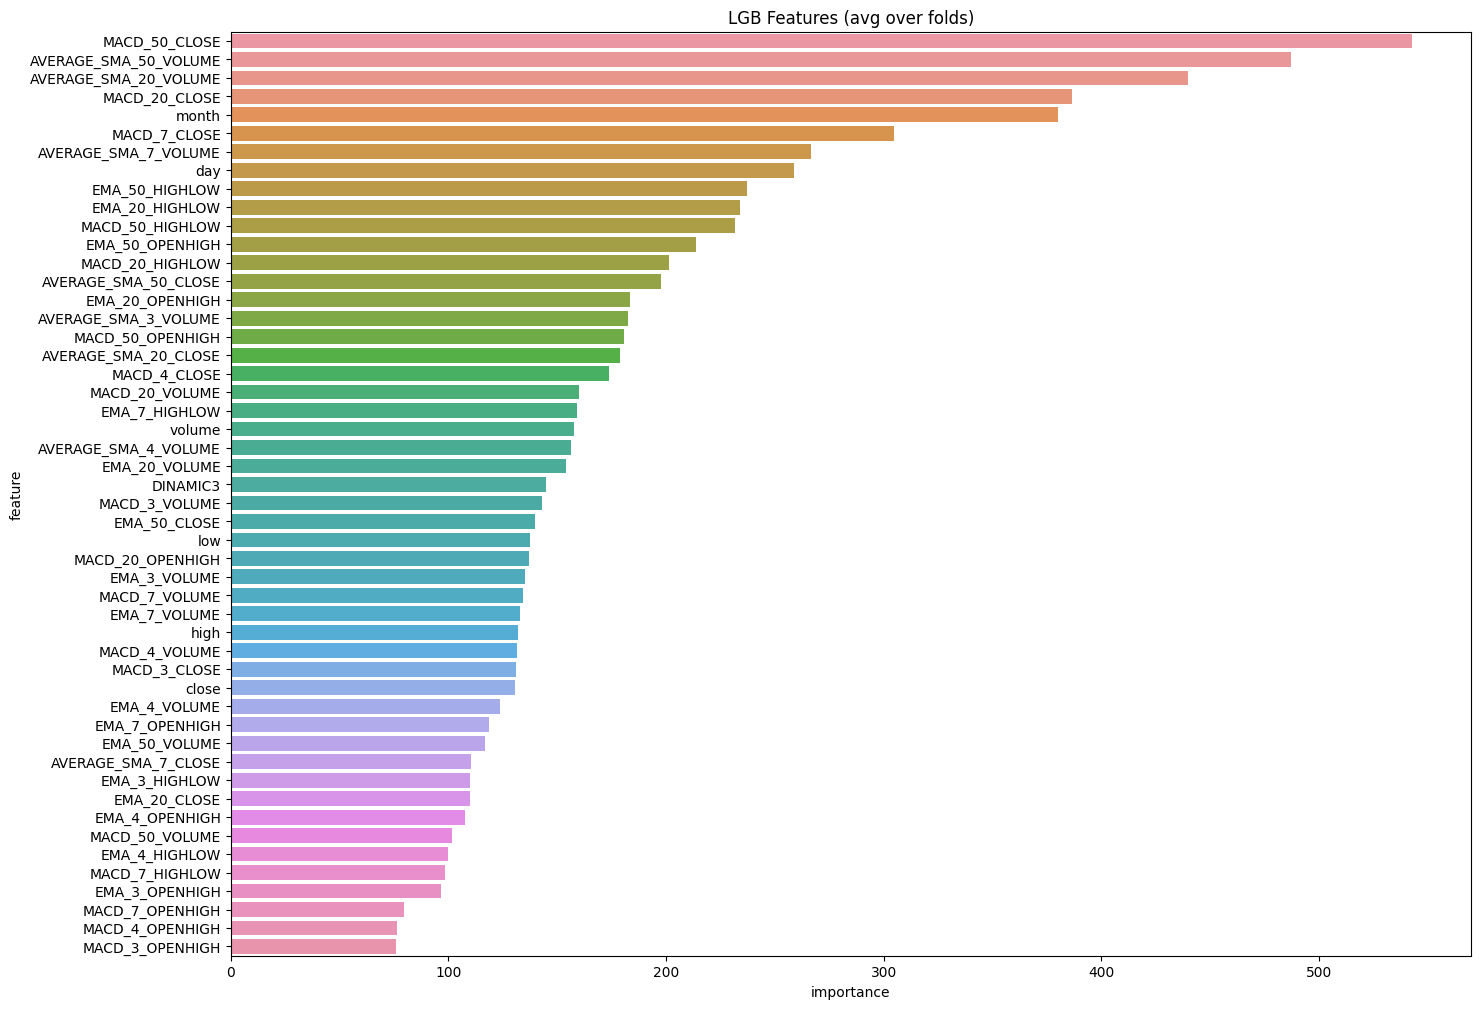

In [22]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
# plt.show(block=False)
# plt.pause(5)
plt.savefig(pathOutput + "BOLSA_feature_importances.png")
# plt.close()



In [23]:
print("COMIENZO DE VALIDACIÓN")
score = metrics.mean_absolute_error(valid_y, model.predict(valid_X))
print('CV score: {0:.4f}.'.format(score))
print("FIN DE VALIDACIÓN")


COMIENZO DE VALIDACIÓN
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
CV score: 0.0470.
FIN DE VALIDACIÓN


In [24]:
# PREDICCIÓN independiente

test = filter_rows_by_values(test, "TARGET", ["null"])

submission = test[columns]
solucion = test['TARGET']

In [25]:
prediccion = (model.predict(submission) > 0.5).astype("int32")
submission['TARGET']=prediccion

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


<ipython-input-25-8a778d0eb328>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['TARGET']=prediccion


In [26]:
submission=submission.join(test['company'])
submission.set_index(submission.pop('company'), inplace=True)
submission.reset_index(inplace=True)
submission.to_csv(os.path.join(pathOutput, 'Bolsa_DL_submission.csv'), index=False)

In [27]:

# PRECISION independiente
a=solucion
b=prediccion
TP=sum(1 for x,y in zip(a,b) if (x == y and y == 1))
TPandFP=sum(b)
precision= TP / TPandFP
print("TP: ", TP)
print("TP + FP: ", TPandFP)
print("---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: {0:.2f}% <<<<<<------".format(precision * 100))

TP:  71
TP + FP:  117
---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: 60.68% <<<<<<------


In [35]:
ift_mayoritaria = test[test.TARGET == False]
ift_minoritaria = test[test.TARGET == True]
tasaDesbalanceo = round(ift_mayoritaria.shape[0] / ift_minoritaria.shape[0], 2)
print("Imbalance rate = "  + str(ift_mayoritaria.shape[0]) + "/" + str(
        ift_minoritaria.shape[0]) + " = " + str(tasaDesbalanceo))

print("Accuracy improvement rate compared to random: ",
              round(precision / (1/(1+tasaDesbalanceo)), 2))



Imbalance rate = 93534/4658 = 20.08
Accuracy improvement rate compared to random:  12.79


In [37]:
print("PROFITS. Examining individually, without accumulation:")
rentacompleta=test['renta_20dias']
valorrentabase=sum(rentacompleta)/len(rentacompleta)
print("Average return of the complete test set, without filtering: ",valorrentabase)

PROFITS. Examining individually, without accumulation:
Average return of the complete test set, without filtering:  3.23010036552872


In [38]:
a=test['renta_20dias']
b=prediccion
probabilidadessumadasainvertir=sum(x for x,y in zip(a,b) if (y == 1))
numeroinversiones=sum(b)
valorrentaainvertir= probabilidadessumadasainvertir / numeroinversiones

print("Average return of the test set where it would invest, with filtering: ",  valorrentaainvertir)

Average return of the test set where it would invest, with filtering:  -3.972552096130312


In [39]:

b=train
b=b.loc[b['TARGET'] == 1]
probabilidadessumadas=sum(b['renta_20dias'])
numeroinversiones=len(b)
rentasolucion= probabilidadessumadas / numeroinversiones

print("Average profitability of the solution set (TRAIN) ", rentasolucion)



Average profitability of the solution set (TRAIN)  3.2633087657192625
